# PyTorch实战: CIFAR10图像分类

## 1 任务目标

### 1.1 用多层感知机(MLP)和卷积网络(ConvNet)完成CIFAR10分类

   使用PyTorch分别实现多层感知机(MLP)和卷积网络(ConvNet)，并完成CIFAR10数据集（http://www.cs.toronto.edu/~kriz/cifar.html） 分类。本案例不提供初始代码，请自行配置网络和选取超参数，包括层数、卷积核数目、激活函数类型、损失函数类型、优化器等方面。

   提交所有代码和一份案例报告，要求如下：

- 详细介绍所使用的模型及其结果，至少包括超参数选取，损失函数、准确率及其曲线；

- 比较不同模型配置下的结果，<font color='red'>至少从三个方面</font>作比较和分析，例如层数、卷积核数目、激活函数类型、损失函数类型、优化器等。

### 1.2 学习PyTorch ImageNet分类示例

   请自行学习PyTorch官方提供的ImageNet分类示例代码，以便更好地完成后续案例(https://github.com/pytorch/examples/tree/master/imagenet)，这部分无需提交代码和报告。

### 1.3 注意事项

- 提交所有代码和一份案例报告；

- 禁止任何形式的抄袭。

## 2 代码设计
导入相应库

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

### 2.1 初始化及数据预处理
1. 设置设备

In [2]:
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('training on', device)

training on cuda


2. 数据预处理以及数据增强
    
    该部分负责在创建数据集时，对数据进行数据增强和预处理，具体操作如下：
    - 训练集数据处理：
        
        - 随机水平翻转`RandomHorizontalFlip()`：以0.5的概率随机水平翻转图像。
        
        - 随机旋转`RandomRotation(5)`：在-5度到5度之间随机旋转图像。
        
        - 颜色抖动`ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)`：对图像进行颜色抖动，包括亮度、对比度和饱和度的随机变化。
        
        - 随机裁剪`RandomResizedCrop(32, scale=(0.9, 1.0))`：对图像进行随机裁剪，然后重新调整大小到指定的尺寸（这里是32x32像素）。
        
        - 张量转换`ToTensor()`：将图像转换为PyTorch张量。

        - 图像标准化`Normalize`：对图像进行标准化，将像素值缩放到[-1, 1]的范围。

    - 测试集数据处理：

        - 张量转换`ToTensor()`：将图像转换为PyTorch张量。
        
        - 图像标准化`Normalize`：对图像进行标准化，将像素值缩放到[-1, 1]的范围。

        
    

In [3]:
# 数据增强和预处理
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(32, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

3. 数据集创建

    CIFAR-10 数据集是一个用于图像分类的常用数据集，该数据集包含了10个类别的彩色图像，每个类别有6,000张图像，共计60,000张图像。每张图像的尺寸是32x32像素。

    该部分用于下载CIFAR-10数据集，并按指定预处理操作，创建训练集和测试集。
    - `torchvision.datasets.CIFAR10`: 这是PyTorch中专门用于加载CIFAR-10数据集的类。
    - `root='./data'`: 这指定了数据集将被下载到的本地目录。
    - `train=True`和`train=False`: 当train=True时，表示创建训练集；当train=False时，表示创建测试集。
    - `download=True`: 如果本地没有找到CIFAR-10数据集，设置为True时，PyTorch将自动下载并解压缩数据集。
    - `transform=transform`: 这里的transform参数指定了数据集中图像的预处理操作。

In [4]:
# 加载CIFAR-10数据集并进行划分
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


4. 创建数据加载器

    创建用于训练和测试的数据加载器（DataLoader）。`train_loader`用于训练，`test_loader`用于测试。
    
    这些数据加载器在训练和测试过程中会循环提供每个批次的图像和标签，方便使用PyTorch的模型进行训练和评估。

    - `torch.utils.data.DataLoader`: 这是PyTorch中的一个类，用于从数据集中加载批量的数据。
    - `batch_size=64`: 这指定了每个批次加载的图像数量。
    - `shuffle=True`和`shuffle=False`: 这表示是否在每个epoch开始时随机打乱数据。在训练集中，通常希望打乱数据以防止模型学到数据的顺序性，而在测试集中则可以保持数据的原始顺序。
    - `num_workers=2`: 这指定了用于加载数据的子进程数量。

In [5]:
# 创建数据加载器
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

5. 显示数据集图片

    将一个批次（64）的数据集图像及标签通过 `Matplotlib` 显示出来。

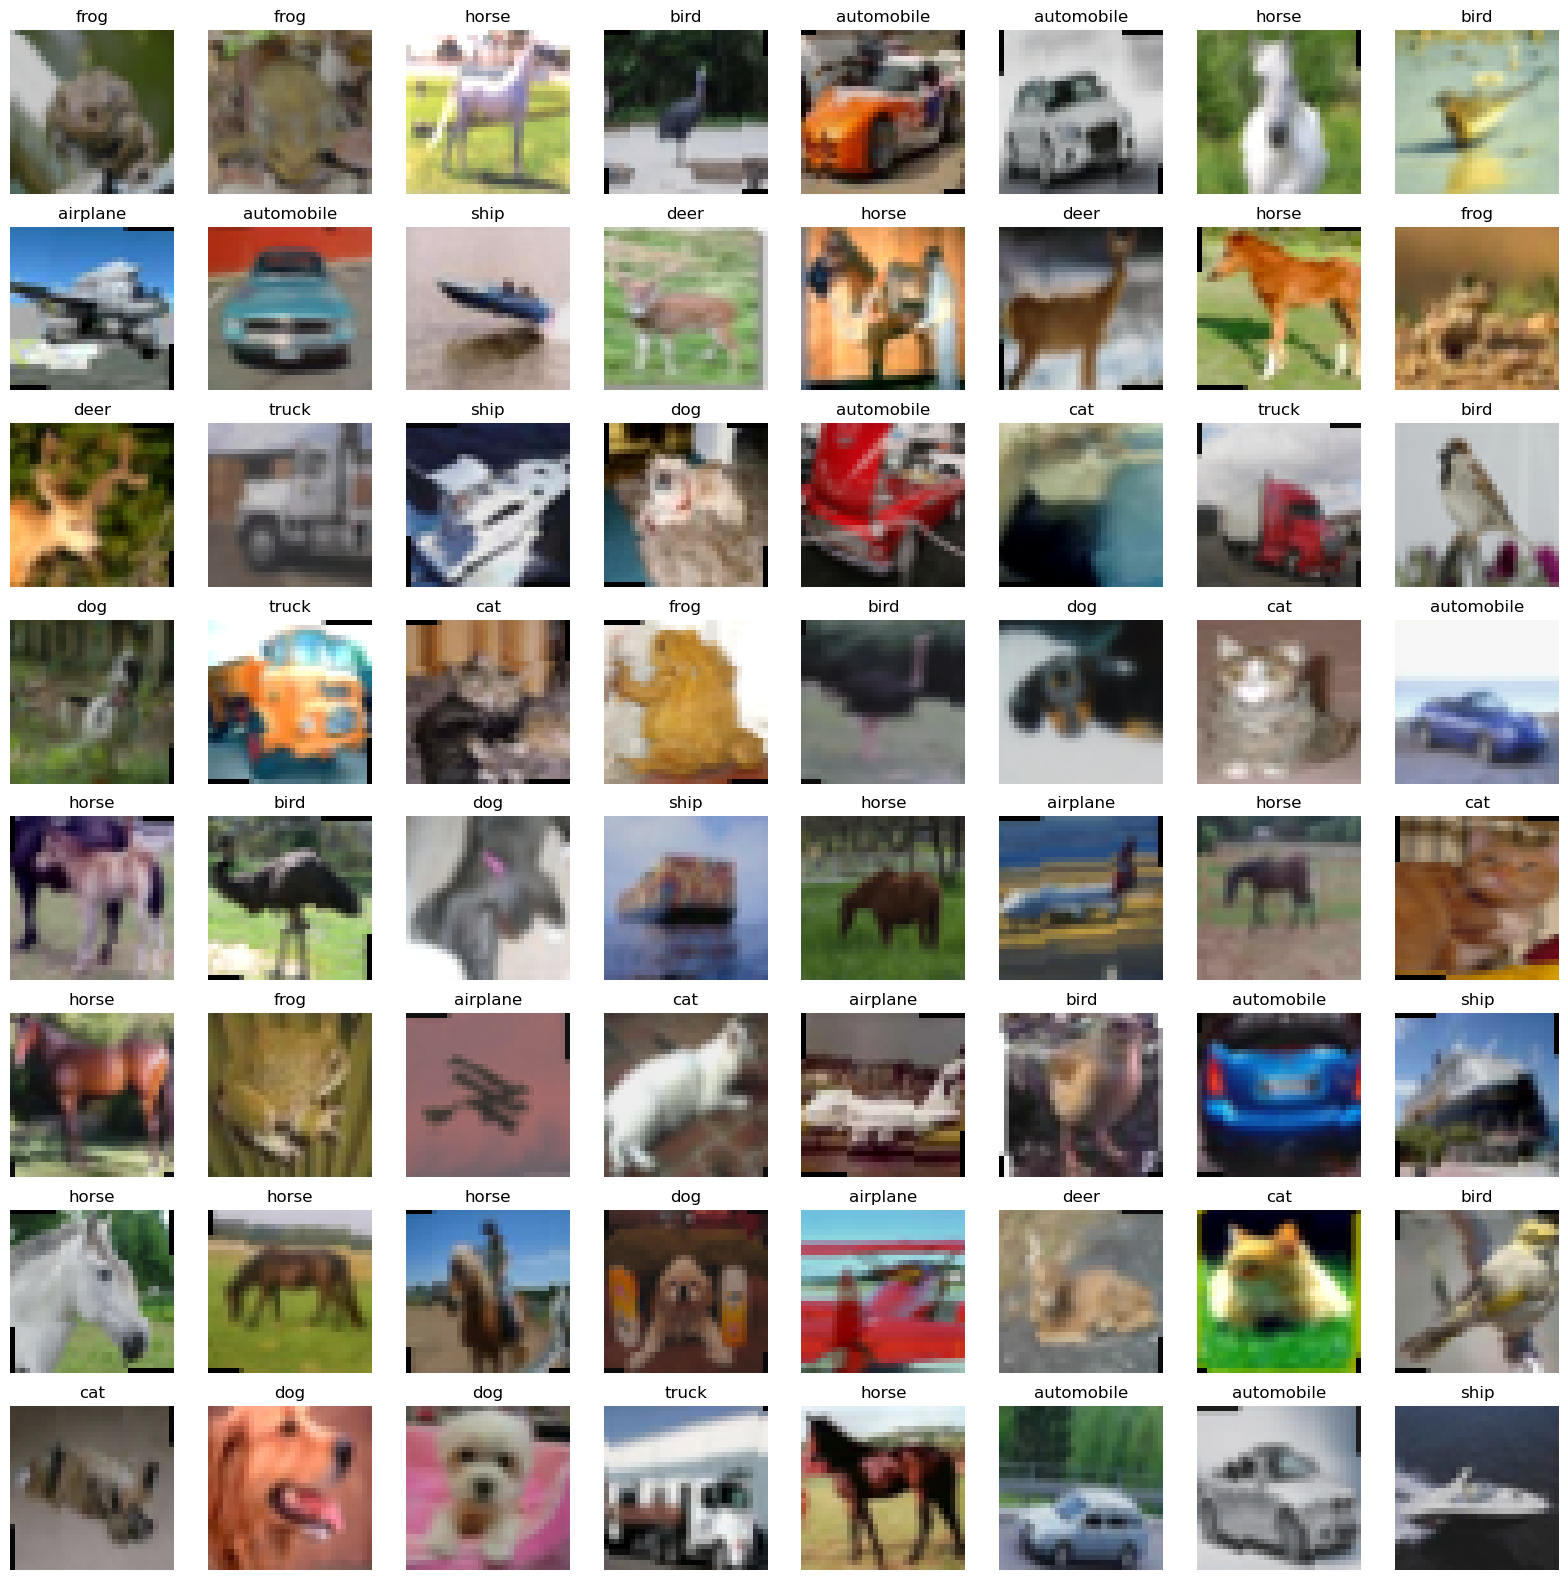

In [6]:
# 获取一个批次的图像和标签
for images, labels in train_loader:
    break  # 获取第一个批次后就跳出循环

# 将张量转换为NumPy数组
images = images.numpy()

# 反归一化
images = (images * 0.5) + 0.5

# 定义标签对应的类别名称
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 显示图像和标签
plt.figure(figsize=(20, 20))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(np.transpose(images[i], (1, 2, 0)))
    plt.title(class_names[labels[i]])
    plt.axis('off')

plt.show()

可以看到，显示出的图像经过了数据增强，有的图像经过了旋转、翻转以及缩放。

### 2.2 模型建立
1. 建立MLP模型

    MLP模型由三个全连接层组成，通过ReLU激活函数进行非线性变换，最终输出一个10维的张量，表示对每个类别的预测得分。

In [7]:
# 定义MLP模型
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

2. 建立简单卷积神经网络模型

    这个ConvNet模型包含了两个卷积层和两个全连接层，通过ReLU激活函数进行非线性变换，并通过最大池化进行下采样。

In [8]:
# 定义ConvNet模型
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = ConvNet()
# 定义一个虚拟的输入张量
input_tensor = torch.randn(1, 3, 32, 32)  # 1个样本，3个通道，32x32的图像

# 前向传播，获取每一层的输出大小
with torch.no_grad():
    conv1_output = model.conv1(input_tensor)
    pool1_output = model.pool(torch.relu(conv1_output))
    conv2_output = model.conv2(pool1_output)
    pool2_output = model.pool(torch.relu(conv2_output))

print("Conv1 output size:", conv1_output.size())
print("Pool1 output size:", pool1_output.size())
print("Conv2 output size:", conv2_output.size())
print("Pool2 output size:", pool2_output.size())

Conv1 output size: torch.Size([1, 64, 32, 32])
Pool1 output size: torch.Size([1, 64, 16, 16])
Conv2 output size: torch.Size([1, 128, 16, 16])
Pool2 output size: torch.Size([1, 128, 8, 8])


3. 建立自定义MLP模型
    
    在这个 DefMLP 模型中，可以调整层数`num_layers`,激活函数 `activation_func`。

In [10]:
class DefMLP(nn.Module):
    def __init__(self, num_layers, activation_func):
        super(DefMLP, self).__init__()

        layers = []
        input_size = 32 * 32 * 3
        for _ in range(num_layers):
            layers.append(nn.Linear(input_size, 512))
            input_size = 512  # 更新输入大小
            if activation_func == 'relu':
                layers.append(nn.ReLU())
            elif activation_func == 'sigmoid':
                layers.append(nn.Sigmoid())
            else:
                raise ValueError("Invalid activation function")

        self.layers = nn.Sequential(*layers)
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        x = self.fc(x)
        return x

4. 建立包含BN层的卷积神经网络模型


In [9]:
# 定义卷积神经网络模型（包含BN层）
class ConvNetBN(nn.Module):
    def __init__(self):
        super(ConvNetBN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.bn3(self.fc1(x)))
        x = self.fc2(x)
        return x

### 2.3 模型训练

1. 建立训练函数

    本次实验采用了两种训练函数，一种是普通的训练函数，另一种是采用早停法的训练函数。

    - `train(model, optimizer, criterion, num_epochs)`：训练&测试函数，根据输入的模型`model`、优化器`optimizer`以及损失函数`criterion`进行指定轮次`num_epochs`的训练。训练后，在测试集上进行测试，并将训练集、测试集上该轮次的准确率和损失记录，并返回。

    - `train_with_early_stopping(model, optimizer, criterion, num_epochs, patience=3)`：采用早停法的训练函数，输出参数里比以上函数多了个`patience`，代表若训练时若测试集上的loss连续3次都未降低则停止训练。

In [15]:
# 训练函数
def train(model, optimizer, criterion, num_epochs):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # 在测试集上评估模型
        model.eval()
        running_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_accuracy = correct_test / total_test
        test_losses.append(running_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracy:.4f}')

    return train_losses, train_accuracies, test_losses, test_accuracies

基于早停法的训练函数：

In [14]:
def train_with_early_stopping(model, optimizer, criterion, num_epochs, patience=3):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    model.to(device)

    best_validation_loss = float('inf')  # 初始最佳验证集损失为正无穷
    early_stopping_counter = 0  # 连续未减小的epoch计数器

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # 在验证集上评估模型
        model.eval()
        running_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

            test_accuracy = correct_test / total_test
            test_losses.append(running_loss / len(test_loader))
            test_accuracies.append(test_accuracy)

            print(f'Epoch {epoch + 1}/{num_epochs}, '
                  f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.4f}, '
                  f'Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracy:.4f}')

            # 判断是否进行早停
            if test_losses[-1] < best_validation_loss:
                best_validation_loss = test_losses[-1]
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            if early_stopping_counter >= patience:
                print(f'Validation loss has not decreased for {patience} consecutive epochs. Early stopping...')
                break

    return train_losses, train_accuracies, test_losses, test_accuracies

2. 绘制曲线函数

In [11]:
def drawlines(train_losses, train_accuracies, test_losses, test_accuracies):
    # 绘制损失和准确率曲线
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title(f'Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title(f'Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

#### 2.3.1 训练普通卷积网络
1. 对比MLP网络不同参数的差异

    对比不同MLP层数、激活函数、优化器对MLP网络训练的影响

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/40, Train Loss: 1.6379, Train Acc: 0.4163, Test Loss: 1.4929, Test Acc: 0.4715
Epoch 2/40, Train Loss: 1.4320, Train Acc: 0.4961, Test Loss: 1.4139, Test Acc: 0.4943
Epoch 3/40, Train Loss: 1.3141, Train Acc: 0.5373, Test Loss: 1.4057, Test Acc: 0.5049
Epoch 4/40, Train Loss: 1.2165, Train Acc: 0.5691, Test Loss: 1.4035, Test Acc: 0.5037
Epoch 5/40, Train Loss: 1.1334, Train Acc: 0.5959, Test Loss: 1.3744, Test Acc: 0.5268
Epoch 6/40, Train Loss: 1.0451, Train Acc: 0.6293, Test Loss: 1.4091, Test Acc: 0.5313
Epoch 7/40, Train Loss: 0.9686, Train Acc: 0.6548, Test Loss: 1.4320, Test Acc: 0.5386
Epoch 8/40, Train Loss: 0.8900, Train Acc: 0.6837, Test Loss: 1.4587, Test Acc: 0.5375
Epoch 9/40, Train Loss: 0.8151, Train Acc: 0.7094, Test Loss: 1.5576, Test Acc: 0.5310
Epoch 10/40, Train Loss: 0.7380, Train Acc: 0.7385, Test Loss: 1.6559, Test Acc: 0.5300
Epoch 11/40, Train Loss: 0.6795, Train Acc: 0.7603, T

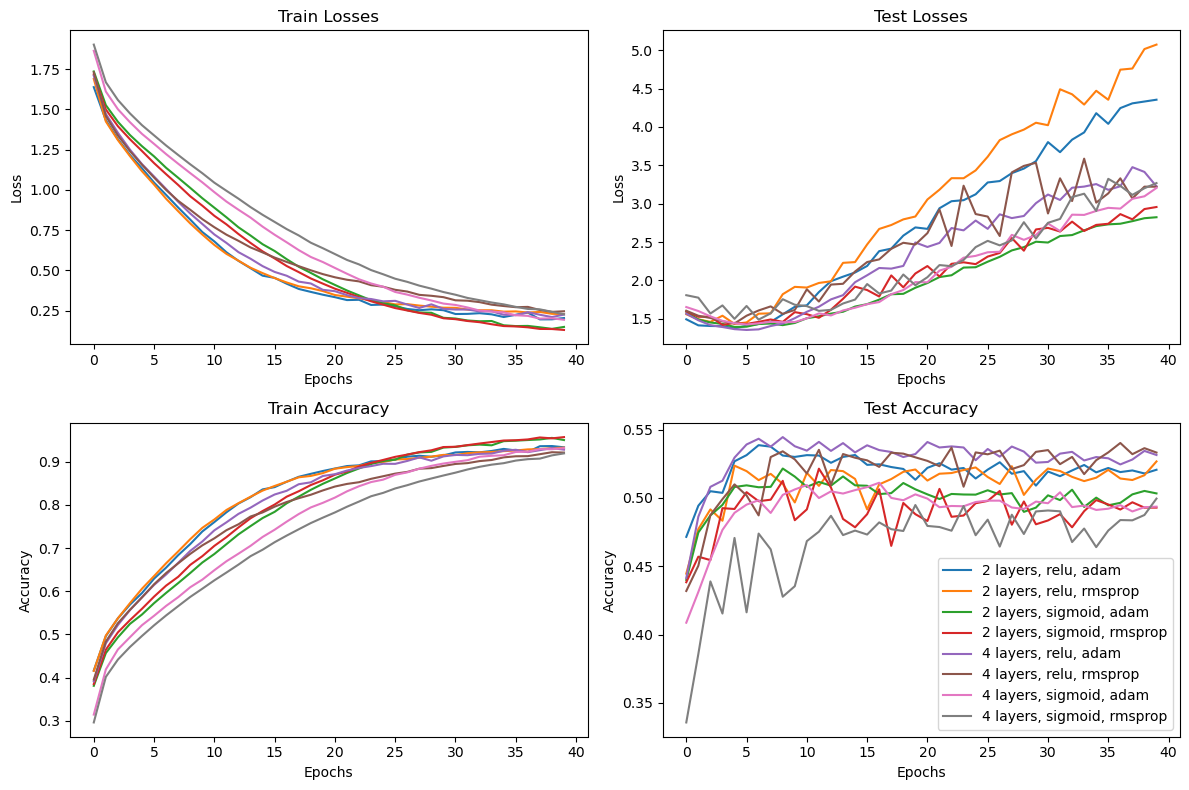

In [ ]:
# 实验不同配置
configs = [
    {'num_layers': 2, 'activation_func': 'relu', 'optimizer': 'adam'},
    {'num_layers': 2, 'activation_func': 'relu', 'optimizer': 'rmsprop'},
    {'num_layers': 2, 'activation_func': 'sigmoid', 'optimizer': 'adam'},
    {'num_layers': 2, 'activation_func': 'sigmoid', 'optimizer': 'rmsprop'},
    {'num_layers': 4, 'activation_func': 'relu', 'optimizer': 'adam'},
    {'num_layers': 4, 'activation_func': 'relu', 'optimizer': 'rmsprop'},
    {'num_layers': 4, 'activation_func': 'sigmoid', 'optimizer': 'adam'},
    {'num_layers': 4, 'activation_func': 'sigmoid', 'optimizer': 'rmsprop'},
]


# 训练并绘制曲线
plt.figure(figsize=(12, 8))

for config in configs:
    model = DefMLP(num_layers=config['num_layers'], activation_func=config['activation_func']).to(device)
    criterion = nn.CrossEntropyLoss()

    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif config['optimizer'] == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=0.001)
    else:
        raise ValueError("Invalid optimizer")

    train_losses, train_accuracies, test_losses, test_accuracies = train(model, optimizer, criterion)

    # 训练集的损失和准确率
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label=f'{config["num_layers"]} layers, {config["activation_func"]}, {config["optimizer"]}')
    plt.title(f'Train Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')


    # 测试集的损失和准确率
    plt.subplot(2, 2, 2)
    plt.plot(test_losses, label=f'{config["num_layers"]} layers, {config["activation_func"]}, {config["optimizer"]}')
    plt.title(f'Test Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # 训练集的准确率
    plt.subplot(2, 2, 3)
    plt.plot(train_accuracies, label=f'{config["num_layers"]} layers, {config["activation_func"]}, {config["optimizer"]}')
    plt.title(f'Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # 测试集的准确率
    plt.subplot(2, 2, 4)
    plt.plot(test_accuracies, label=f'{config["num_layers"]} layers, {config["activation_func"]}, {config["optimizer"]}')
    plt.title(f'Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

plt.legend()
plt.tight_layout()
plt.show()

2. 对比学习率对模型卷积网络的影响

    - CNN1：采用交叉熵为损失函数，SGD作为优化器，学习率为0.01，动量为0.9

    - CNN2：采用交叉熵为损失函数，SGD作为优化器，学习率为0.001，动量为0.9

Epoch 1/20, Train Loss: 1.5601, Train Acc: 0.4363, Test Loss: 1.2043, Test Acc: 0.5626
Epoch 2/20, Train Loss: 1.1469, Train Acc: 0.5928, Test Loss: 0.9880, Test Acc: 0.6494
Epoch 3/20, Train Loss: 0.9766, Train Acc: 0.6567, Test Loss: 0.8655, Test Acc: 0.7006
Epoch 4/20, Train Loss: 0.8689, Train Acc: 0.6947, Test Loss: 0.8426, Test Acc: 0.7077
Epoch 5/20, Train Loss: 0.7742, Train Acc: 0.7287, Test Loss: 0.7532, Test Acc: 0.7430
Epoch 6/20, Train Loss: 0.7067, Train Acc: 0.7561, Test Loss: 0.7467, Test Acc: 0.7439
Epoch 7/20, Train Loss: 0.6421, Train Acc: 0.7752, Test Loss: 0.7182, Test Acc: 0.7586
Epoch 8/20, Train Loss: 0.5873, Train Acc: 0.7951, Test Loss: 0.7057, Test Acc: 0.7624
Epoch 9/20, Train Loss: 0.5390, Train Acc: 0.8125, Test Loss: 0.6936, Test Acc: 0.7746
Epoch 10/20, Train Loss: 0.4936, Train Acc: 0.8280, Test Loss: 0.7024, Test Acc: 0.7720
Epoch 11/20, Train Loss: 0.4501, Train Acc: 0.8441, Test Loss: 0.7214, Test Acc: 0.7808
Epoch 12/20, Train Loss: 0.4161, Train Ac

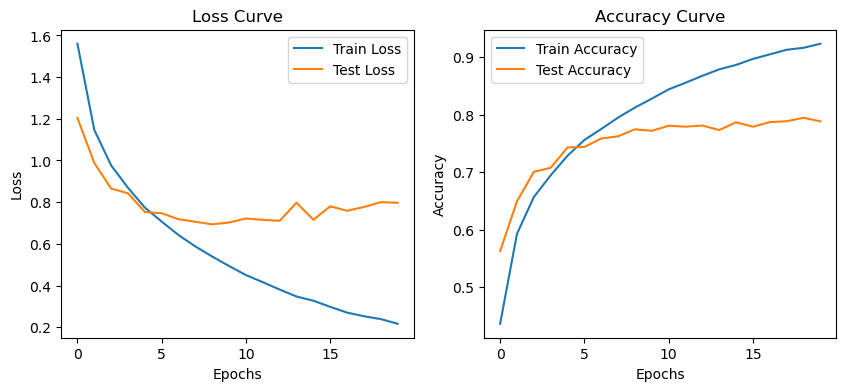

In [16]:
model = ConvNet().to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 训练模型
num_epochs = 20
train_losses_cnn1, train_accuracies_cnn1, test_losses_cnn1, test_accuracies_cnn1 = train(model, optimizer, criterion, num_epochs)

drawlines(train_losses_cnn1, train_accuracies_cnn1, test_losses_cnn1, test_accuracies_cnn1)

Epoch 1/20, Train Loss: 2.0021, Train Acc: 0.2906, Test Loss: 1.7500, Test Acc: 0.3823
Epoch 2/20, Train Loss: 1.6634, Train Acc: 0.4112, Test Loss: 1.4922, Test Acc: 0.4741
Epoch 3/20, Train Loss: 1.4937, Train Acc: 0.4701, Test Loss: 1.4211, Test Acc: 0.4929
Epoch 4/20, Train Loss: 1.3959, Train Acc: 0.5053, Test Loss: 1.2944, Test Acc: 0.5331
Epoch 5/20, Train Loss: 1.3174, Train Acc: 0.5340, Test Loss: 1.2270, Test Acc: 0.5620
Epoch 6/20, Train Loss: 1.2670, Train Acc: 0.5528, Test Loss: 1.1640, Test Acc: 0.5857
Epoch 7/20, Train Loss: 1.2124, Train Acc: 0.5748, Test Loss: 1.1842, Test Acc: 0.5783
Epoch 8/20, Train Loss: 1.1596, Train Acc: 0.5948, Test Loss: 1.1386, Test Acc: 0.5922
Epoch 9/20, Train Loss: 1.1183, Train Acc: 0.6098, Test Loss: 1.0487, Test Acc: 0.6240
Epoch 10/20, Train Loss: 1.0788, Train Acc: 0.6224, Test Loss: 1.0501, Test Acc: 0.6313
Epoch 11/20, Train Loss: 1.0380, Train Acc: 0.6380, Test Loss: 1.0012, Test Acc: 0.6489
Epoch 12/20, Train Loss: 1.0095, Train Ac

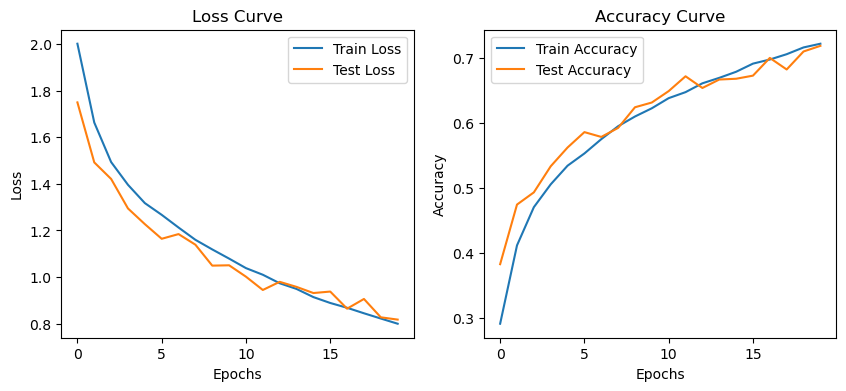

In [25]:
model = ConvNet().to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 训练模型
num_epochs = 20
train_losses_cnn2, train_accuracies_cnn2, test_losses_cnn2, test_accuracies_cnn2 = train(model, optimizer, criterion, num_epochs)

drawlines(train_losses_cnn2, train_accuracies_cnn2, test_losses_cnn2, test_accuracies_cnn2)

3. 对比批归一化对卷积网络的影响

Epoch 1/20, Train Loss: 1.2500, Train Acc: 0.5549, Test Loss: 1.0502, Test Acc: 0.6307
Epoch 2/20, Train Loss: 0.9502, Train Acc: 0.6643, Test Loss: 0.8636, Test Acc: 0.7075
Epoch 3/20, Train Loss: 0.8258, Train Acc: 0.7117, Test Loss: 0.8405, Test Acc: 0.7126
Epoch 4/20, Train Loss: 0.7401, Train Acc: 0.7409, Test Loss: 0.7069, Test Acc: 0.7559
Epoch 5/20, Train Loss: 0.6733, Train Acc: 0.7671, Test Loss: 0.7679, Test Acc: 0.7401
Epoch 6/20, Train Loss: 0.6110, Train Acc: 0.7876, Test Loss: 0.6721, Test Acc: 0.7766
Epoch 7/20, Train Loss: 0.5581, Train Acc: 0.8049, Test Loss: 0.6724, Test Acc: 0.7713
Epoch 8/20, Train Loss: 0.5228, Train Acc: 0.8195, Test Loss: 0.6389, Test Acc: 0.7892
Epoch 9/20, Train Loss: 0.4835, Train Acc: 0.8323, Test Loss: 0.6285, Test Acc: 0.7957
Epoch 10/20, Train Loss: 0.4471, Train Acc: 0.8435, Test Loss: 0.6469, Test Acc: 0.7850
Epoch 11/20, Train Loss: 0.4219, Train Acc: 0.8534, Test Loss: 0.6561, Test Acc: 0.7951
Epoch 12/20, Train Loss: 0.3917, Train Ac

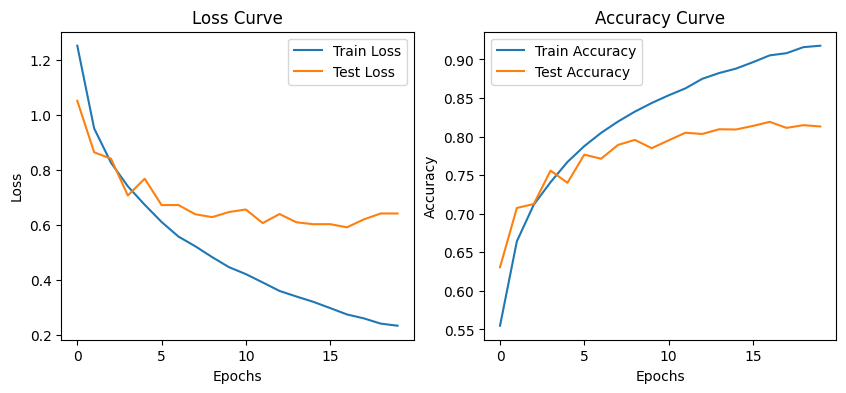

In [17]:
# 批归一化

# 选择模型
model = ConvNetBN().to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 训练模型
num_epochs = 20
train_losses, train_accuracies, test_losses, test_accuracies = train(model, optimizer, criterion, num_epochs)

# 绘制曲线
drawlines(train_losses, train_accuracies, test_losses, test_accuracies)

4. 采用早停法，减少训练时间

Epoch 1/20, Train Loss: 1.2570, Train Acc: 0.5516, Test Loss: 1.0395, Test Acc: 0.6323
Epoch 2/20, Train Loss: 0.9560, Train Acc: 0.6624, Test Loss: 0.8703, Test Acc: 0.6968
Epoch 3/20, Train Loss: 0.8287, Train Acc: 0.7106, Test Loss: 0.7678, Test Acc: 0.7374
Epoch 4/20, Train Loss: 0.7412, Train Acc: 0.7418, Test Loss: 0.7397, Test Acc: 0.7414
Epoch 5/20, Train Loss: 0.6690, Train Acc: 0.7664, Test Loss: 0.6638, Test Acc: 0.7727
Epoch 6/20, Train Loss: 0.6104, Train Acc: 0.7877, Test Loss: 0.6799, Test Acc: 0.7644
Epoch 7/20, Train Loss: 0.5653, Train Acc: 0.8032, Test Loss: 0.6368, Test Acc: 0.7850
Epoch 8/20, Train Loss: 0.5252, Train Acc: 0.8170, Test Loss: 0.6510, Test Acc: 0.7854
Epoch 9/20, Train Loss: 0.4850, Train Acc: 0.8322, Test Loss: 0.6114, Test Acc: 0.7958
Epoch 10/20, Train Loss: 0.4451, Train Acc: 0.8462, Test Loss: 0.5943, Test Acc: 0.8003
Epoch 11/20, Train Loss: 0.4227, Train Acc: 0.8516, Test Loss: 0.6080, Test Acc: 0.8048
Epoch 12/20, Train Loss: 0.3967, Train Ac

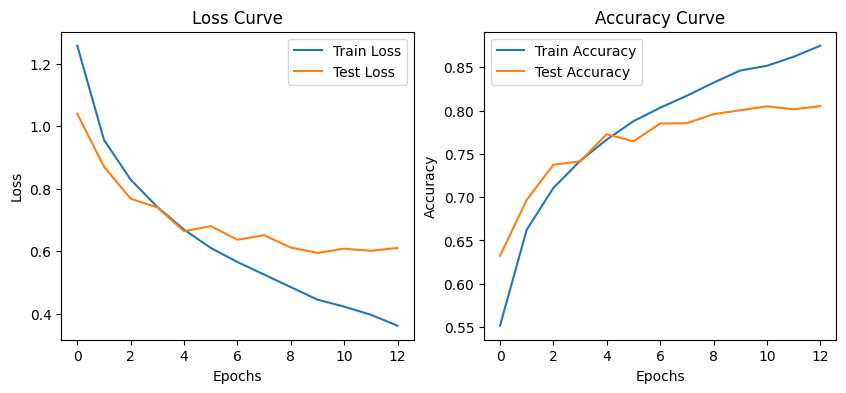

In [16]:
# 早停法

# 选择模型
model = ConvNetBN().to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 训练模型
num_epochs = 20

# 调用训练函数
train_losses, train_accuracies, test_losses, test_accuracies = train_with_early_stopping(model, optimizer, criterion, num_epochs, patience=5)

# 绘制曲线
drawlines(train_losses, train_accuracies, test_losses, test_accuracies)

5. 采用早停法+Adam优化器训练卷积网络

Epoch 1/20, Train Loss: 1.3292, Train Acc: 0.5263, Test Loss: 0.9821, Test Acc: 0.6522
Epoch 2/20, Train Loss: 0.9744, Train Acc: 0.6564, Test Loss: 0.9293, Test Acc: 0.6823
Epoch 3/20, Train Loss: 0.8506, Train Acc: 0.7043, Test Loss: 0.7761, Test Acc: 0.7321
Epoch 4/20, Train Loss: 0.7587, Train Acc: 0.7354, Test Loss: 0.8050, Test Acc: 0.7235
Epoch 5/20, Train Loss: 0.6915, Train Acc: 0.7609, Test Loss: 0.7402, Test Acc: 0.7583
Epoch 6/20, Train Loss: 0.6350, Train Acc: 0.7794, Test Loss: 0.7258, Test Acc: 0.7591
Epoch 7/20, Train Loss: 0.5894, Train Acc: 0.7935, Test Loss: 0.7017, Test Acc: 0.7757
Epoch 8/20, Train Loss: 0.5438, Train Acc: 0.8094, Test Loss: 0.7218, Test Acc: 0.7678
Epoch 9/20, Train Loss: 0.5058, Train Acc: 0.8263, Test Loss: 0.6735, Test Acc: 0.7824
Epoch 10/20, Train Loss: 0.4742, Train Acc: 0.8377, Test Loss: 0.6926, Test Acc: 0.7836
Epoch 11/20, Train Loss: 0.4427, Train Acc: 0.8461, Test Loss: 0.6824, Test Acc: 0.7882
Epoch 12/20, Train Loss: 0.4176, Train Ac

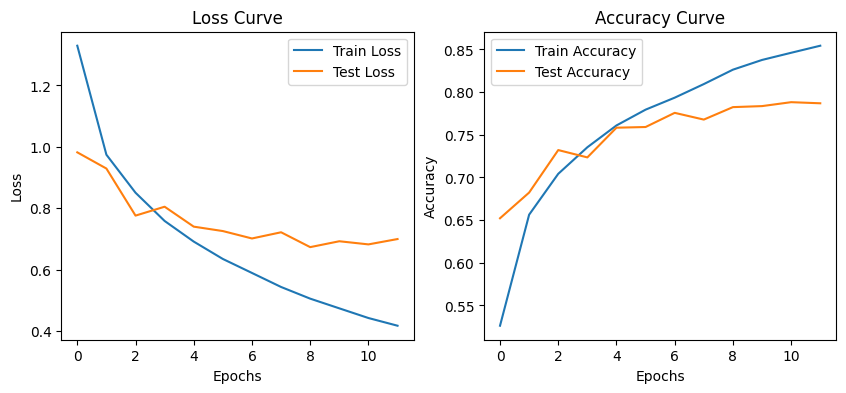

In [13]:
# 早停法+Adam优化器

# 选择模型
model = ConvNetBN().to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 训练模型
num_epochs = 20

# 调用训练函数
train_losses, train_accuracies, test_losses, test_accuracies = train_with_early_stopping(model, optimizer, criterion, num_epochs)

# 绘制曲线
drawlines(train_losses, train_accuracies, test_losses, test_accuracies)

6. ResNet模型

Epoch 1/20, Train Loss: 1.1356, Train Acc: 0.6148, Test Loss: 0.7501, Test Acc: 0.7449
Epoch 2/20, Train Loss: 0.7723, Train Acc: 0.7375, Test Loss: 0.7328, Test Acc: 0.7561
Epoch 3/20, Train Loss: 0.6747, Train Acc: 0.7718, Test Loss: 0.6026, Test Acc: 0.7992
Epoch 4/20, Train Loss: 0.5797, Train Acc: 0.7997, Test Loss: 0.5902, Test Acc: 0.8049
Epoch 5/20, Train Loss: 0.5320, Train Acc: 0.8175, Test Loss: 0.5474, Test Acc: 0.8128
Epoch 6/20, Train Loss: 0.4903, Train Acc: 0.8320, Test Loss: 0.5296, Test Acc: 0.8244
Epoch 7/20, Train Loss: 0.4564, Train Acc: 0.8432, Test Loss: 0.5816, Test Acc: 0.8150
Epoch 8/20, Train Loss: 0.4252, Train Acc: 0.8535, Test Loss: 0.5193, Test Acc: 0.8267
Epoch 9/20, Train Loss: 0.3953, Train Acc: 0.8628, Test Loss: 0.5019, Test Acc: 0.8342
Epoch 10/20, Train Loss: 0.3711, Train Acc: 0.8704, Test Loss: 0.4958, Test Acc: 0.8360
Epoch 11/20, Train Loss: 0.3520, Train Acc: 0.8760, Test Loss: 0.5080, Test Acc: 0.8365
Epoch 12/20, Train Loss: 0.3309, Train Ac

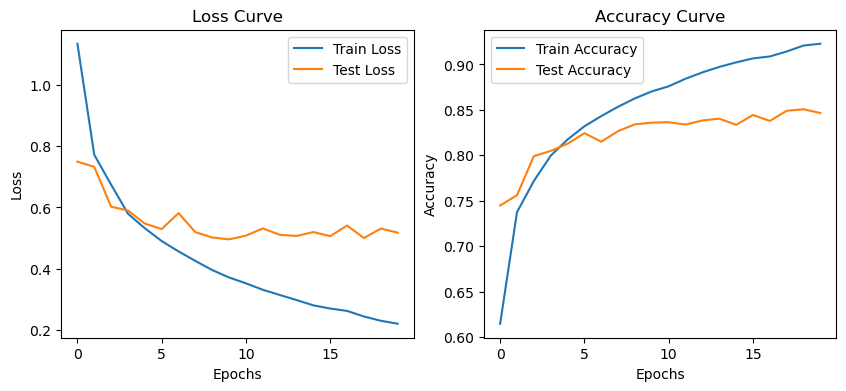

In [18]:
# 选择模型
model = torchvision.models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 训练模型
num_epochs = 20

# 调用训练函数
train_losses, train_accuracies, test_losses, test_accuracies = train(model, optimizer, criterion, num_epochs)

# 绘制曲线
drawlines(train_losses, train_accuracies, test_losses, test_accuracies)

d:\Software\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Software\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Train Loss: 0.8701, Train Acc: 0.7003, Test Loss: 0.5370, Test Acc: 0.8185
Epoch 2/10, Train Loss: 0.5211, Train Acc: 0.8205, Test Loss: 0.4360, Test Acc: 0.8519
Epoch 3/10, Train Loss: 0.4249, Train Acc: 0.8555, Test Loss: 0.4321, Test Acc: 0.8455
Epoch 4/10, Train Loss: 0.3572, Train Acc: 0.8769, Test Loss: 0.4030, Test Acc: 0.8646
Epoch 5/10, Train Loss: 0.3117, Train Acc: 0.8923, Test Loss: 0.3840, Test Acc: 0.8752
Epoch 6/10, Train Loss: 0.2789, Train Acc: 0.9042, Test Loss: 0.3686, Test Acc: 0.8791
Epoch 7/10, Train Loss: 0.2525, Train Acc: 0.9113, Test Loss: 0.3607, Test Acc: 0.8830
Epoch 8/10, Train Loss: 0.2248, Train Acc: 0.9218, Test Loss: 0.3456, Test Acc: 0.8910
Epoch 9/10, Train Loss: 0.1991, Train Acc: 0.9297, Test Loss: 0.3583, Test Acc: 0.8888
Epoch 10/10, Train Loss: 0.1894, Train Acc: 0.9338, Test Loss: 0.3651, Test Acc: 0.8906
Epoch 1/10, Train Loss: 0.1035, Train Acc: 0.9646, Test Loss: 0.3028, Test Acc: 0.9084
Epoch 2/10, Train Loss: 0.0812, Train Acc:

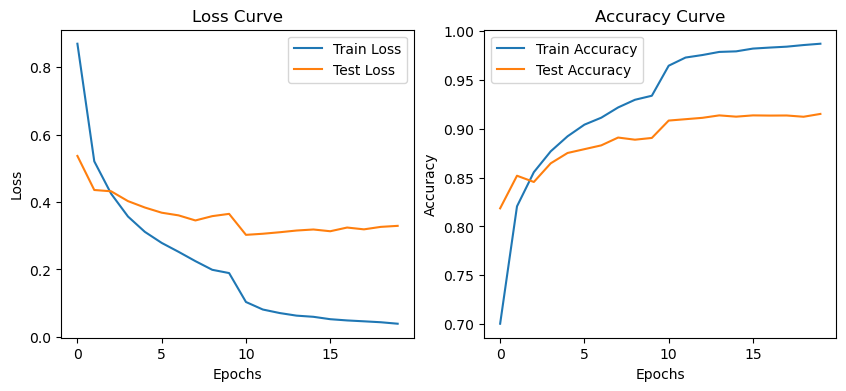

In [23]:
# 加载预训练的ResNet18模型
resnet18_pretrained = torchvision.models.resnet18(pretrained=True)

# 修改最后的全连接层以适应CIFAR-10的类别数（10类）
num_features = resnet18_pretrained.fc.in_features
resnet18_pretrained.fc = nn.Linear(num_features, 10)

# 添加Batch Normalization层
model = nn.Sequential(
    resnet18_pretrained.conv1,
    resnet18_pretrained.bn1,
    resnet18_pretrained.relu,
    resnet18_pretrained.layer1,
    resnet18_pretrained.layer2,
    resnet18_pretrained.layer3,
    resnet18_pretrained.layer4,
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),  # 将特征张量展平
    nn.BatchNorm1d(num_features),  # Batch Normalization层
    nn.Linear(num_features, 10),  # 新的全连接层
)


# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer_1 = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer_2 = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 调用训练函数
train_losses_1, train_accuracies_1, test_losses_1, test_accuracies_1 = train(model, optimizer_1, criterion, num_epochs=10)
train_losses_2, train_accuracies_2, test_losses_2, test_accuracies_2 = train(model, optimizer_2, criterion, num_epochs=10)

# 绘制曲线
drawlines(train_losses_1+train_losses_2, train_accuracies_1+train_accuracies_2, test_losses_1+test_losses_2, test_accuracies_1+test_accuracies_2)

Epoch 1/40, Train Loss: 0.9271, Train Acc: 0.6852, Test Loss: 0.6342, Test Acc: 0.7862
Epoch 2/40, Train Loss: 0.6261, Train Acc: 0.7873, Test Loss: 0.5130, Test Acc: 0.8208
Epoch 3/40, Train Loss: 0.5168, Train Acc: 0.8232, Test Loss: 0.4566, Test Acc: 0.8426
Epoch 4/40, Train Loss: 0.4548, Train Acc: 0.8451, Test Loss: 0.4441, Test Acc: 0.8480
Epoch 5/40, Train Loss: 0.4044, Train Acc: 0.8618, Test Loss: 0.4310, Test Acc: 0.8570
Epoch 6/40, Train Loss: 0.3661, Train Acc: 0.8753, Test Loss: 0.4325, Test Acc: 0.8522
Epoch 7/40, Train Loss: 0.3322, Train Acc: 0.8862, Test Loss: 0.4172, Test Acc: 0.8605
Epoch 8/40, Train Loss: 0.3001, Train Acc: 0.8961, Test Loss: 0.4656, Test Acc: 0.8541
Epoch 9/40, Train Loss: 0.2726, Train Acc: 0.9062, Test Loss: 0.4079, Test Acc: 0.8690
Epoch 10/40, Train Loss: 0.2485, Train Acc: 0.9127, Test Loss: 0.3852, Test Acc: 0.8718
Epoch 11/40, Train Loss: 0.2246, Train Acc: 0.9218, Test Loss: 0.3973, Test Acc: 0.8745
Epoch 12/40, Train Loss: 0.2108, Train Ac

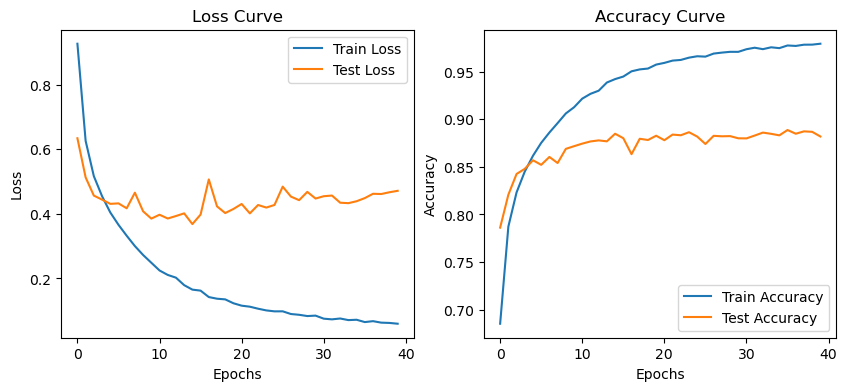

In [24]:
# 加载预训练的ResNet18模型
resnet18_pretrained = torchvision.models.resnet18(pretrained=True)

# 修改最后的全连接层以适应CIFAR-10的类别数（10类）
num_features = resnet18_pretrained.fc.in_features
resnet18_pretrained.fc = nn.Linear(num_features, 10)

# 添加Batch Normalization层
model = nn.Sequential(
    resnet18_pretrained.conv1,
    resnet18_pretrained.bn1,
    resnet18_pretrained.relu,
    resnet18_pretrained.layer1,
    resnet18_pretrained.layer2,
    resnet18_pretrained.layer3,
    resnet18_pretrained.layer4,
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),  # 将特征张量展平
    nn.BatchNorm1d(num_features),  # Batch Normalization层
    nn.Linear(num_features, 10),  # 新的全连接层
)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# 训练模型
num_epochs = 40

# 调用训练函数
train_losses, train_accuracies, test_losses, test_accuracies = train(model, optimizer, criterion, num_epochs)

# 绘制曲线
drawlines(train_losses, train_accuracies, test_losses, test_accuracies)